# Figure generation notebook for *Bayesian Inference Reveals Permissive and Nonpermissive Channel Closings in CFTR*

This notebook generates Figures 2, 3, and 4 for the above-named paper. 

The notebook is written in Python 3 and requires numpy and matplotlib. It also uses Python's built-in csv library.

The notebook reads data from the Repository directory, which should be placed in the same directory as this notebook. The Reposito

In [1]:
# required libraries and processing functions - execute this cell first

import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt

# reads results if known parameters or last EM results only are selected
def readCSV(f):

    with open(f) as csvfile:
        r = csv.reader(csvfile)
        m = []
        for i in r:
            m.append(list(i))
        
    paramList = m[:-1]
    results = m[-1]
    
    return paramList,results

def readCSVpc(f,encoding=None):

    if encoding is None:
        with open(f) as csvfile:
            r = csv.reader(csvfile)
            m = []
            for i in r:
                m.append(list(i))
    else:
        with open(f,encoding=encoding) as csvfile:
            r = csv.reader(csvfile)
            m = []
            for i in r:
                m.append(list(i))
                
    return m

# reads results if full EM results are selected
def readCSVem(f):
    
    with open(f) as csvfile:
        r = csv.reader(csvfile)
        m = []
        for i in r:
            m.append(list(i))
    
    a = len(m) # here half the lists are parameters, half are results
    paramList = m[:int(a/2)]
    results = m[int(a/2):]
    
    return paramList,results

def readCSVOneLine(f,encoding=None):
    
    return readCSVpc(f,encoding=encoding)[0]

def processResults(paramList,results,paramIndex,unique=True):
    
    allIndices = [float(paramList[i][paramIndex]) for i in range(0,len(paramList))]


    # if unique is True, then we take the sum over unique indices 
    # if False, we preserve all indices separately
    if (unique is False):
        uniqueIndices = np.array(allIndices)
        cResults = np.array([float(results[i]) for i in range(0,len(results))])
        indicesCount = np.array([float(paramList[i][0]) for i in range(0,len(results))])
    else:
        uniqueIndices = []
        for r in allIndices:
            if (r not in uniqueIndices):
                uniqueIndices.append(r)

        uniqueIndices.sort()

        cResults = np.zeros(len(uniqueIndices))
        indicesCount = np.zeros(len(uniqueIndices))
        for i in range(0,len(results)):
            j = uniqueIndices.index(float(paramList[i][paramIndex]))
            indicesCount[j] += float(paramList[i][0]) # at this location we have the number of estimates
            cResults[j] += float(results[i])
   
    cResults = cResults / indicesCount
    
    return uniqueIndices,cResults

# a formatter to allow axis decorations with order of magnitude
class MagnitudeFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, exponent=None):
        super().__init__()
        self._fixed_exponent = exponent

    def _set_order_of_magnitude(self):
        if self._fixed_exponent:
            self.orderOfMagnitude = self._fixed_exponent
        else:
            super()._set_order_of_magnitude()

def parseConfResult(r):
    # results of this kind are of the form '[ a b]' where a and b are integers
    # need to strip the brackets and whitespace
    r = r[1:-1] # strip the brackets
    r = r.split() # split on whitespace, eliminates left and right whitespace
    return int(r[0]),int(r[1])
  
def parseVectorResult(r):
    # results of this kind are of the form '[ a b]' where a and b are integers
    # need to strip the brackets and whitespace
    r = r[1:-1] # strip the brackets
    r = r.split() # split on whitespace, eliminates left and right whitespace
    return np.array([int(r[i]) for i in range(0,len(r))])

def string2float_list(l):
    r = []
    for i in range(0,len(l)):
        r.append(float(l[i]))
        
    return r

# plots f with respect to t, but omits points where f = x
def plotExclude(ax,t,f,x,line='-',clr='green',lw=2):
    
    # find runs that do not include x
    frun = []
    trun = []
    inRun = False
    for i in range(0,len(t)):
        if (f[i] != x):
            if (inRun is False):
                # start a run
                inRun = True
            frun.append(f[i])
            trun.append(t[i])
        if (inRun is True) and ((f[i] == x) or (i == len(t)-1)):
            # end the run and plot
            ax.plot(trun,frun,linestyle=line,color=clr,linewidth=lw)
            frun = []
            trun = []
            inRun = False

def readData(pathPrefix,fname_pre,fname_raw,fname_10,fname_100):       
    # read the raw data
    data = string2float_list(readCSVOneLine(pathPrefix + fname_pre))
    rawdata = string2float_list(np.array(readCSVpc(pathPrefix + fname_raw,encoding='utf-8-sig'))[:,1])

    # read the estimates ... estimates are the 3rd line of the file, estimates with reliability are the 4th line
    # the first 2 lines have the parameters and can be ignored
    e_10 = readCSVpc(pathPrefix + fname_10)
    e_100 = readCSVpc(pathPrefix + fname_100)


    e_10_est = string2float_list(e_10[2])
    e_10_conf = string2float_list(e_10[3])
    e_100_est = string2float_list(e_100[2])
    e_100_conf = string2float_list(e_100[3])

    t = np.arange(len(data))*500e-6*50
    t_raw = np.arange(len(rawdata))*500e-6
    
    return data,rawdata,e_10_est,e_10_conf,e_100_est,e_100_conf,t,t_raw

# wherever we find a value from old_map in v, we replace it with the corresponding value of new_map
def remap(old_map,new_map,v):
    r = np.zeros(len(v))
    for i in range(0,len(v)):
        for j in range(0,len(old_map)):
            if v[i] == old_map[j]:
                r[i] = new_map[j]
                
    return r

def figsHelper(ax,
               fn,
               num_index,
               den_index,
               lineColor,
               markerColor,
               complementProbability=True,
               dataPoints=True,
               paramID=10,
               axisScale=1):
  
  m_params = []
  
  ax.set_box_aspect(1)
  
  a,b = readCSV(fn)

  for i in range(0,len(b)):
    m_params.append(a[i])
    if i == 0:
      m_results = np.array([parseVectorResult(b[i])])
    else:
      m_results = np.append(m_results,np.array([parseVectorResult(b[i])]),axis=0)

  par = []
  num = []
  den = []
  for i in range(0,np.shape(m_results)[0]):
    if m_results[i,0] != 0:
      par.append(m_params[i])
      num.append(m_results[i,num_index])
      den.append(m_results[i,den_index])
  num = np.array(num)
  den = np.array(den)

  if dataPoints is True:
    x,y = processResults(par,num*20000/den,paramID,unique=False)
    if complementProbability is True:
      ax.plot(np.array(x)*axisScale,1-y,linestyle='',marker='.',color=markerColor,markersize=1)
    else:
      ax.plot(np.array(x)*axisScale,y,linestyle='',marker='.',color=markerColor,markersize=1)

  x,y = processResults(par,num*20000/den,paramID,unique=True)
  if complementProbability is True:
    ax.plot(np.array(x)*axisScale,1-y,linestyle='-',color=lineColor)
  else:
    ax.plot(np.array(x)*axisScale,y,linestyle='-',color=lineColor)

def confidenceFigs(ax,fn,fnc,num_index=1,den_index=0,complementProbability=False,paramID=10):
  figsHelper(ax,fn,num_index,den_index,'#0000ff','#a0a0ff',complementProbability,paramID=paramID)
  figsHelper(ax,fnc,num_index,den_index,'#ff0000','#ffa0a0',complementProbability,paramID=paramID)

def transition(v,firstState,lastState):
  # find a specific transition
  currentLocation = 1
  transitionIndices = []

  while (currentLocation < len(v)):

    if (v[currentLocation-1] == firstState) and (v[currentLocation] == lastState):
      transitionIndices.append(currentLocation)

    currentLocation += 1

  return transitionIndices

def isNonPermissiveClosing(v,index):
  
  # v[index] should be '5.0'  
  if v[index] != '5.0':
    return False
  
  n = nextOpen(v,index)
  
  if n == np.Inf:
    return False
  
  if v[n] == '3.0':
    return True
  
  return False

def nextOpen(v,index):
  return getIndexOfNextState(v,index,['3.0','4.0'])

def readCSVsimple(f):

    with open(f) as csvfile:
        r = csv.reader(csvfile)
        m = []
        for i in r:
            m.append(list(i))
            
    return m
  
# state is a list, we return the index of the next appearance of a state in the list
def getIndexOfNextState(v,start,state):
  currentLocation = start+1
  
  while currentLocation < len(v):
    if (v[currentLocation] not in state):
      currentLocation += 1
    else:
      return currentLocation
    
  return np.Inf # this makes it easier to compare

def getClosings(filename):
  
  m = readCSVsimple(filename)

  r_c = transition(m[3],'4.0','5.0')
  r = transition(m[2],'4.0','5.0')
  r_np_c = []
  r_np = []
  for i in r:
    if isNonPermissiveClosing(m[2],i):
      r_np.append(i)
      if i in r_c:
        r_np_c.append(i)

  r.extend(transition(m[2],'3.0','2.0'))
  r_c.extend(transition(m[3],'3.0','2.0'))

  return r,r_c,r_np,r_np_c


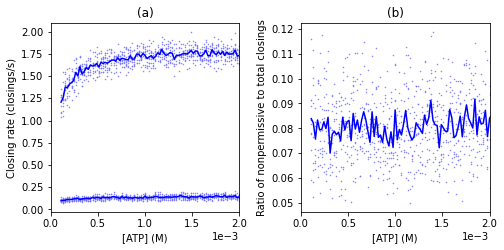

In [2]:
# This cell generates Figure 2. The figure is displayed and saved as: Fig2.pdf

atpc = 1/90 # for converting probabilities back to nominal ATP concentrations

fig, (ax2,ax1) = plt.subplots(nrows=1,ncols=2,figsize=(7,7))


figsHelper(ax1,'Repository/Fig2/closingCount.csv',1,0,'#0000ff','#7777ff',
           complementProbability=False,dataPoints=True,paramID=3,axisScale=atpc)


ax2.set_box_aspect(1)
p,r = readCSV('Repository/Fig2/closingCount.csv')
allClosings = [parseConfResult(i)[0] for i in r]
nonPermissiveClosings = [parseConfResult(i)[1] for i in r]

acu = processResults(p,allClosings,3,unique=True)
acn = processResults(p,allClosings,3,unique=False)
npcu = processResults(p,nonPermissiveClosings,3,unique=True)
npcn = processResults(p,nonPermissiveClosings,3,unique=False)

ax2.plot(np.array(acn[0])*atpc,acn[1]*100,linestyle='',marker='.',markersize=1,color='#7777ff')
ax2.plot(np.array(acu[0])*atpc,acu[1]*100,linestyle='-',color='#0000ff')
ax2.plot(np.array(npcn[0])*atpc,npcn[1]*100,linestyle='',marker='.',markersize=1,color='#7777ff')
ax2.plot(np.array(npcu[0])*atpc,npcu[1]*100,linestyle='-',color='#0000ff')

ax_v = [ax1,ax2]

for ax in ax_v:
  ax.xaxis.set_major_formatter(MagnitudeFormatter(-3))
  ax.set_xlim(0,0.002)
  ax.set_xlabel('[ATP] (M)')
              
ax1.set_ylabel('Ratio of nonpermissive to total closings')
ax2.set_ylabel('Closing rate (closings/s)')

ax1.set_title('(b)')
ax2.set_title('(a)')

fig.tight_layout(pad=1)

fig.savefig('Fig2.pdf',bbox_inches='tight',pad_inches=0.05)


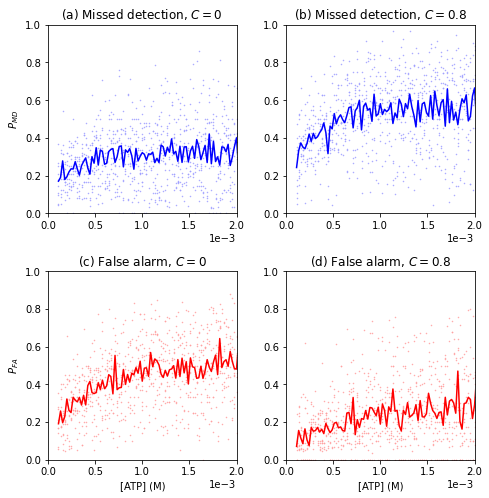

In [3]:
# This cell generates Figure 3. The figure is displayed and saved as: Fig3.pdf

atpc = 1/90 # for converting probabilities back to nominal ATP concentrations

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(7,7))

figsHelper(ax1,'Repository/Fig3/ml002v.csv',1,0,'#0000ff','#a0a0ff',
           complementProbability=True,dataPoints=True,paramID=3,axisScale=atpc)

figsHelper(ax2,'Repository/Fig3/mlc002v.csv',1,0,'#0000ff','#a0a0ff',
           complementProbability=True,dataPoints=True,paramID=3,axisScale=atpc)

figsHelper(ax3,'Repository/Fig3/al002v.csv',1,0,'#ff0000','#ffa0a0',
           complementProbability=True,dataPoints=True,paramID=3,axisScale=atpc)

figsHelper(ax4,'Repository/Fig3/alc002v.csv',1,0,'#ff0000','#ffa0a0',
           complementProbability=True,dataPoints=True,paramID=3,axisScale=atpc)

ax3.set_xlabel('[ATP] (M)')
ax4.set_xlabel('[ATP] (M)')

ax1.set_ylabel('$P_{MD}$')
ax3.set_ylabel('$P_{FA}$')

ax_v = [ax1,ax2,ax3,ax4]

ax1.set_title('(a) Missed detection, $C = 0$')
ax2.set_title('(b) Missed detection, $C = 0.8$')
ax3.set_title('(c) False alarm, $C = 0$')
ax4.set_title('(d) False alarm, $C = 0.8$')

for ax in ax_v:
  ax.xaxis.set_major_formatter(MagnitudeFormatter(-3))
  ax.set_xlim(0,0.002)
  ax.set_ylim(0,1)
  
fig.tight_layout(pad=1)

fig.savefig('Fig3.pdf',bbox_inches='tight',pad_inches=0.05)

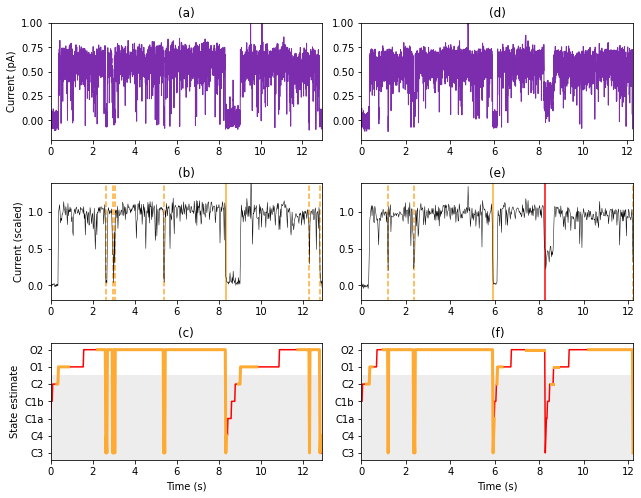

In [5]:
# This cell generates Figure 4. The figure is displayed and saved as: Fig4.pdf

data1,rawdata1,e1_10_est,e1_10_conf,e1_100_est,e1_100_conf,t1,t1_raw = readData('Repository/Fig4/',
                                                                                'n17000-preprocessed.csv',
                                                                                'n17000-raw.csv',
                                                                                'n17000-r10.csv',
                                                                                'n17000-r400.csv')

data2,rawdata2,e2_10_est,e2_10_conf,e2_100_est,e2_100_conf,t2,t2_raw = readData('Repository/Fig4/',
                                                                                'n17004-1-preprocessed.csv',
                                                                                'n17004-1-raw.csv',
                                                                                'n17004-1-r10.csv',
                                                                                'n17004-1-r400.csv')

fig, ((ax1,ax4), (ax2,ax5), (ax3,ax6)) = plt.subplots(nrows=3,ncols=2,figsize=(9,7))

ax1.plot(t1_raw,np.array(rawdata1),color='#7c2dad',linewidth=1.)
ax1.set_ylabel('Current (pA)')
ax1.set_ylim(-0.2,1)
ax1.set_xlim(t1_raw[0],t1_raw[-1])
ax1.set_title('(a)')

r,r_c,r_np,r_np_c = getClosings('Repository/Fig4/n17000-r400.csv')
for i in r:
  if i in r_np_c:
    ax2.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='#ffaa33',linestyle='-')
    #print(('r_np_c',i))
  elif i in r_np:
    ax2.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='r',linestyle='-')
    #print(('r_np',i))
  elif i in r_c:
    ax2.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='#ffaa33',linestyle='--')
    #print(('r_c',i))
  else:
    ax2.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='r',linestyle='-')
    #print(('r',i))

ax2.plot(t1,np.array(data1),color='#000000',linewidth=0.5)
ax2.set_ylabel('Current (scaled)')
ax2.set_ylim(-0.2,1.4)
ax2.set_xlim(t1[0],t1[-1])
ax2.set_title('(b)')

ax3.plot(t1,remap([0.,1.,2.,3.,4.,5.,6.,-1.],[2.,3.,4.,5.,6.,0.,1.,-1.],e1_100_est),'r-')
plotExclude(ax3,t1,remap([0.,1.,2.,3.,4.,5.,6.,-1.],[2.,3.,4.,5.,6.,0.,1.,-1.],e1_100_conf),-1.,clr='#ffaa33',lw=3)
ax3.set_yticks([0.,1.,2.,3.,4.,5.,6.])
ax3.set_yticklabels(['C3','C4','C1a','C1b','C2','O1','O2'])
ax3.set_ylabel('State estimate')
ax3.set_xlim(t1[0],t1[-1])
ax3.set_ylim(-0.4,6.4)
ax3.axhspan(-0.4,4.5,facecolor='#dddddd',alpha=0.5)
ax3.set_xlabel('Time (s)')
ax3.set_title('(c)')

ax4.plot(t2_raw,np.array(rawdata2),color='#7c2dad',linewidth=1.)
ax4.set_ylim(-0.2,1)
ax4.set_xlim(t2_raw[0],t2_raw[-1])
ax4.set_title('(d)')

r,r_c,r_np,r_np_c = getClosings('Repository/Fig4/n17004-1-r400.csv')
for i in r:
  if i in r_np_c:
    ax5.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='#ffaa33',linestyle='-')
  elif i in r_np:
    ax5.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='r',linestyle='-')
  elif i in r_c:
    ax5.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='#ffaa33',linestyle='--')
  else:
    ax5.plot(np.array([i,i])*(500e-6*50),np.array([-1,2]),color='r',linestyle='--')
    
ax5.plot(t2,np.array(data2),color='#000000',linewidth=0.5)
ax5.set_ylim(-0.2,1.4)
ax5.set_xlim(t2[0],t2[-1])
ax5.set_title('(e)')

ax6.plot(t2,remap([0.,1.,2.,3.,4.,5.,6.,-1.],[2.,3.,4.,5.,6.,0.,1.,-1.],e2_100_est),'r-')
plotExclude(ax6,t2,remap([0.,1.,2.,3.,4.,5.,6.,-1.],[2.,3.,4.,5.,6.,0.,1.,-1.],e2_100_conf),-1.,clr='#ffaa33',lw=3)
ax6.set_yticks([0.,1.,2.,3.,4.,5.,6.])
ax6.set_yticklabels(['C3','C4','C1a','C1b','C2','O1','O2'])
ax6.set_xlim(t2[0],t2[-1])
ax6.set_ylim(-0.4,6.4)
ax6.axhspan(-0.4,4.5,facecolor='#dddddd',alpha=0.5)
ax6.set_xlabel('Time (s)')
ax6.set_title('(f)')

fig.tight_layout(pad=1)
fig.savefig('Fig4.pdf',bbox_inches='tight',pad_inches=0.05)